In [1]:
import sys
import os

current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(current_dir, '../'))

if project_root not in sys.path:
    sys.path.append(project_root)

In [ ]:
import time
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt

from optimizations.pso.pso import PSOFISOptimizer
from fis.fis_model import FISChatbot

/tmp/ipykernel_106360/3384281463.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
DATA_DIR = os.path.join(project_root, "..", "data", "processed")

In [4]:
X_train = np.load(os.path.join(DATA_DIR, "X_train.npy"))
X_test = np.load(os.path.join(DATA_DIR, "X_test.npy"))
y_train = np.load(os.path.join(DATA_DIR, "y_train.npy"))
y_test = np.load(os.path.join(DATA_DIR, "y_test.npy"))

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")

X_train shape: (12800, 6)
y_train shape: (12800,)
X_test shape:  (3200, 6)
y_test shape:  (3200,)


In [6]:
N_EXPERIMENTS = 5       
N_PARTICLES = 20
N_ITERATIONS = 30
BATCH_SIZE = 200
EARLY_STOPPING = 10

# Koefisien PSO
W_INERTIA = 0.7
C1_COGNITIVE = 1.5
C2_SOCIAL = 1.5

pso_results = []
pso_histories = []

print(f"{'='*60}")
print(f"PSO-FIS Optimization Benchmark")
print(f"{'='*60}")
print(f"Config: {N_EXPERIMENTS} runs, Particles={N_PARTICLES}, Iter={N_ITERATIONS}")
print(f"Batch={BATCH_SIZE}, Early Stop={EARLY_STOPPING}")
print(f"{'='*60}\n")

# ==========================================
# Main Experiment Loop
# ==========================================
for i in range(N_EXPERIMENTS):
    print(f"[Run {i+1}/{N_EXPERIMENTS}]")
    
    # 1. Inisialisasi Optimizer
    # Stratified=True agar sampling batch seimbang tiap kelas
    optimizer = PSOFISOptimizer(X_train, y_train, batch_size=BATCH_SIZE, stratified=True)
    
    start_time = time.time()
    
    # 2. Jalankan Optimasi
    best_fitness_train = optimizer.run(
        n_particles=N_PARTICLES,
        n_iterations=N_ITERATIONS,
        w=W_INERTIA, c1=C1_COGNITIVE, c2=C2_SOCIAL,
        early_stopping_rounds=EARLY_STOPPING,
        verbose=False # Set False agar output tidak terlalu panjang
    )
    
    exec_time = time.time() - start_time
    
    # 3. Ambil Model Terbaik & Evaluasi di Test Set
    best_model = optimizer.get_optimized_model()
    y_pred_opt = best_model.predict_batch(X_test)
    
    # 4. Hitung Metrik
    acc = accuracy_score(y_test, y_pred_opt)
    f1 = f1_score(y_test, y_pred_opt, average='weighted')
    
    print(f"  >> Test Acc: {acc:.4f} | F1: {f1:.4f} | Time: {exec_time:.2f}s | Train Fit: {best_fitness_train:.4f}")
    
    # 5. Simpan Hasil
    pso_results.append({
        "run_id": i + 1,
        "accuracy": acc,
        "f1_weighted": f1,
        "execution_time": exec_time,
        "best_fitness_train": best_fitness_train,
        "converged_at": len(optimizer.history) # Mengetahui di iterasi ke berapa dia berhenti
    })
    
    pso_histories.append(optimizer.history)

PSO-FIS Optimization Benchmark
Config: 5 runs, Particles=20, Iter=30
Batch=200, Early Stop=10

[Run 1/5]
  >> Test Acc: 0.4766 | F1: 0.4193 | Time: 354.84s | Train Fit: 0.3586
[Run 2/5]
  >> Test Acc: 0.5203 | F1: 0.4605 | Time: 639.99s | Train Fit: 0.3838
[Run 3/5]
  >> Test Acc: 0.5188 | F1: 0.4576 | Time: 539.73s | Train Fit: 0.4040
[Run 4/5]
  >> Test Acc: 0.5188 | F1: 0.4582 | Time: 625.54s | Train Fit: 0.3939
[Run 5/5]
  >> Test Acc: 0.5091 | F1: 0.4479 | Time: 527.75s | Train Fit: 0.3889


In [9]:
df_results = pd.DataFrame(pso_results)

In [11]:
df_results.sort_values(by='f1_weighted', ascending=False)

,run_id,accuracy,f1_weighted,execution_time,best_fitness_train,converged_at
1,2,0.520312,0.460489,639.987067,0.383838,18
3,4,0.518750,0.458216,625.543367,0.393939,18
2,3,0.518750,0.457596,539.734520,0.404040,17
4,5,0.509062,0.447896,527.751858,0.388889,15
0,1,0.476562,0.419286,354.844675,0.358586,12


In [12]:
best_f1 = df_results["f1_weighted"].max()
print(f"Best F1 Weighted: {best_f1:.4f}")

Best F1 Weighted: 0.4605


In [13]:
total_time = df_results["execution_time"].sum()
print(f"Total Execution Time: {total_time:.2f}s ({total_time/60:.2f} minutes)")

Total Execution Time: 2687.86s (44.80 minutes)


In [17]:
best_acc = df_results["accuracy"].max()
best_run_idx = df_results["f1_weighted"].idxmax()
std_f1 = df_results["f1_weighted"].std()

print("=== PSO Evaluation ===")
print(f"Akurasi              : {best_acc:.4f}")
print(f"F1-Score (weighted)  : {best_f1:.4f}")
print(f"Waktu Eksekusi       : {total_time:.4f} detik ({total_time/60:.2f} menit)")
print(f"Stabilitas(σ)        : {std_f1:.4f}")

=== PSO Evaluation ===
Akurasi              : 0.5203
F1-Score (weighted)  : 0.4605
Waktu Eksekusi       : 2687.8615 detik (44.80 menit)
Stabilitas(σ)        : 0.0171


In [8]:
data_runs = [
    {
        "run": 1,
        "test_acc": 0.4766,
        "f1": 0.4193,
        "time_s": 354.84,
        "train_fit": 0.3586
    },
    {
        "run": 2,
        "test_acc": 0.5203,
        "f1": 0.4605,
        "time_s": 639.99,
        "train_fit": 0.3838
    },
    {
        "run": 3,
        "test_acc": 0.5188,
        "f1": 0.4576,
        "time_s": 539.73,
        "train_fit": 0.4040
    },
    {
        "run": 4,
        "test_acc": 0.5188,
        "f1": 0.4582,
        "time_s": 625.54,
        "train_fit": 0.3939
    },
    {
        "run": 5,
        "test_acc": 0.5091,
        "f1": 0.4479,
        "time_s": 527.75,
        "train_fit": 0.3889
    },
]
df = pd.DataFrame(data_runs)

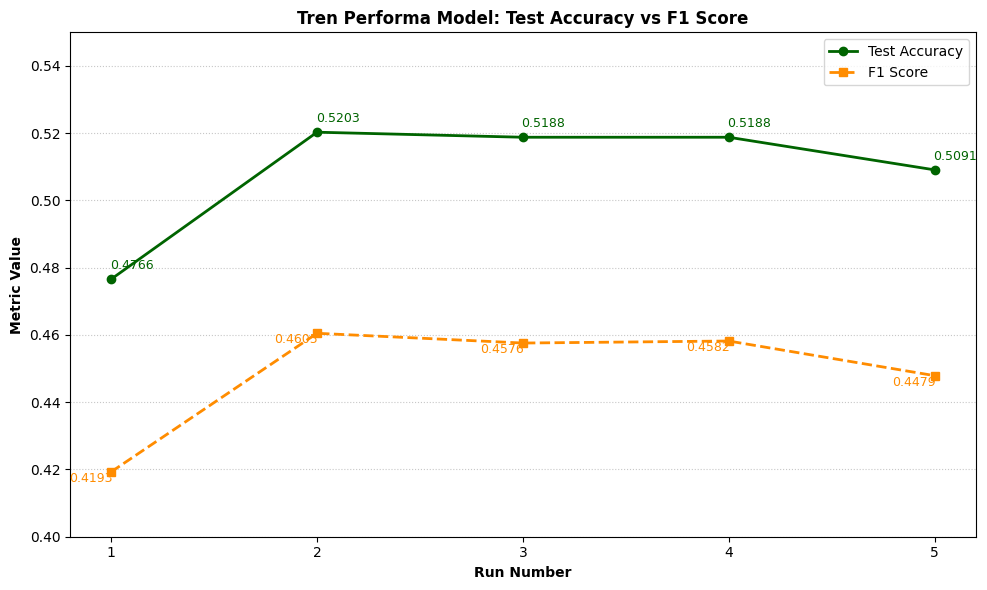

In [9]:
# Membuat Line Plot untuk menunjukkan tren Accuracy dan F1 Score
plt.figure(figsize=(10, 6))

# Plotting Test Accuracy
plt.plot(df['run'], df['test_acc'], marker='o', linestyle='-', color='darkgreen', linewidth=2, label='Test Accuracy')

# Plotting F1 Score
plt.plot(df['run'], df['f1'], marker='s', linestyle='--', color='darkorange', linewidth=2, label='F1 Score')

# Menambahkan label, judul, dan grid
plt.xlabel('Run Number', fontweight='bold')
plt.ylabel('Metric Value', fontweight='bold')
plt.title('Tren Performa Model: Test Accuracy vs F1 Score', fontweight='bold')
plt.xticks(df['run']) # Memastikan label x adalah bilangan bulat 1-5
plt.ylim(0.40, 0.55) # Mengatur batas y untuk fokus pada perbedaan

# Menambahkan nilai di atas titik data
for i in range(len(df)):
    plt.text(df['run'][i] + 0.1, df['test_acc'][i] + 0.003, f"{df['test_acc'][i]:.4f}", color='darkgreen', ha = 'center', fontsize=9)
    plt.text(df['run'][i] - 0.1, df['f1'][i] - 0.003, f"{df['f1'][i]:.4f}", color='darkorange', ha = 'center', fontsize=9)

plt.legend()
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()